# 3. Velocity Joint Probability Distributions

## 3.1. Notebook setup

In [1]:
import os
import sys

import corner
import emcee
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import smplotlib

In [2]:
epochs = ["A", "B", "C", "D", "E", "F"]
data_path = "../data/"
fig_path = "../figures/"
calibrator = "J0340"
target = "HR1099"

cm = [
    "#377eb8",
    "#e41a1c",
    "#4daf4a",
    "#dede00",
    "#ff7f00",
    "#999999",
    "#984ea3",
    "#f781bf",
    "#a65628",
]
marker_cycle = ["o", "v", "X", "<", "D", "^"]

sys.path.append(os.path.join(os.getcwd(), ".."))
from library import HR1099_astrometry

deg = np.pi / 180
mas = deg / (60 * 60 * 1000)

## 3.2. Import data

In [3]:
mean_jd = np.genfromtxt(
    data_path + target + "_I_positions.txt",
    skip_header=2,
    dtype="U5,f8,f8,f8,f8,f8,f8,f8",
    usecols=(5),
    unpack=True,
)
mean_mjd = np.round(mean_jd - 2400000.5, 1)

sampler = emcee.backends.HDFBackend(data_path + target + "_orbital_chain.h5")
flat_samples = sampler.get_chain(flat=True)
flat_samples = np.divide(flat_samples, np.array([1, 1, deg, deg]))

med_val = np.percentile(flat_samples, [16, 50, 84], axis=0)
lower_val = med_val[1] - med_val[0]
upper_val = med_val[2] - med_val[1]
med_val = med_val[1]

hr1099 = HR1099_astrometry.HR1099_astrometry(med_val[2] * deg, med_val[3] * deg)
T, P, d, a, m1, m2, R1, R2 = hr1099.hr1099_info()

## 3.3. Plot

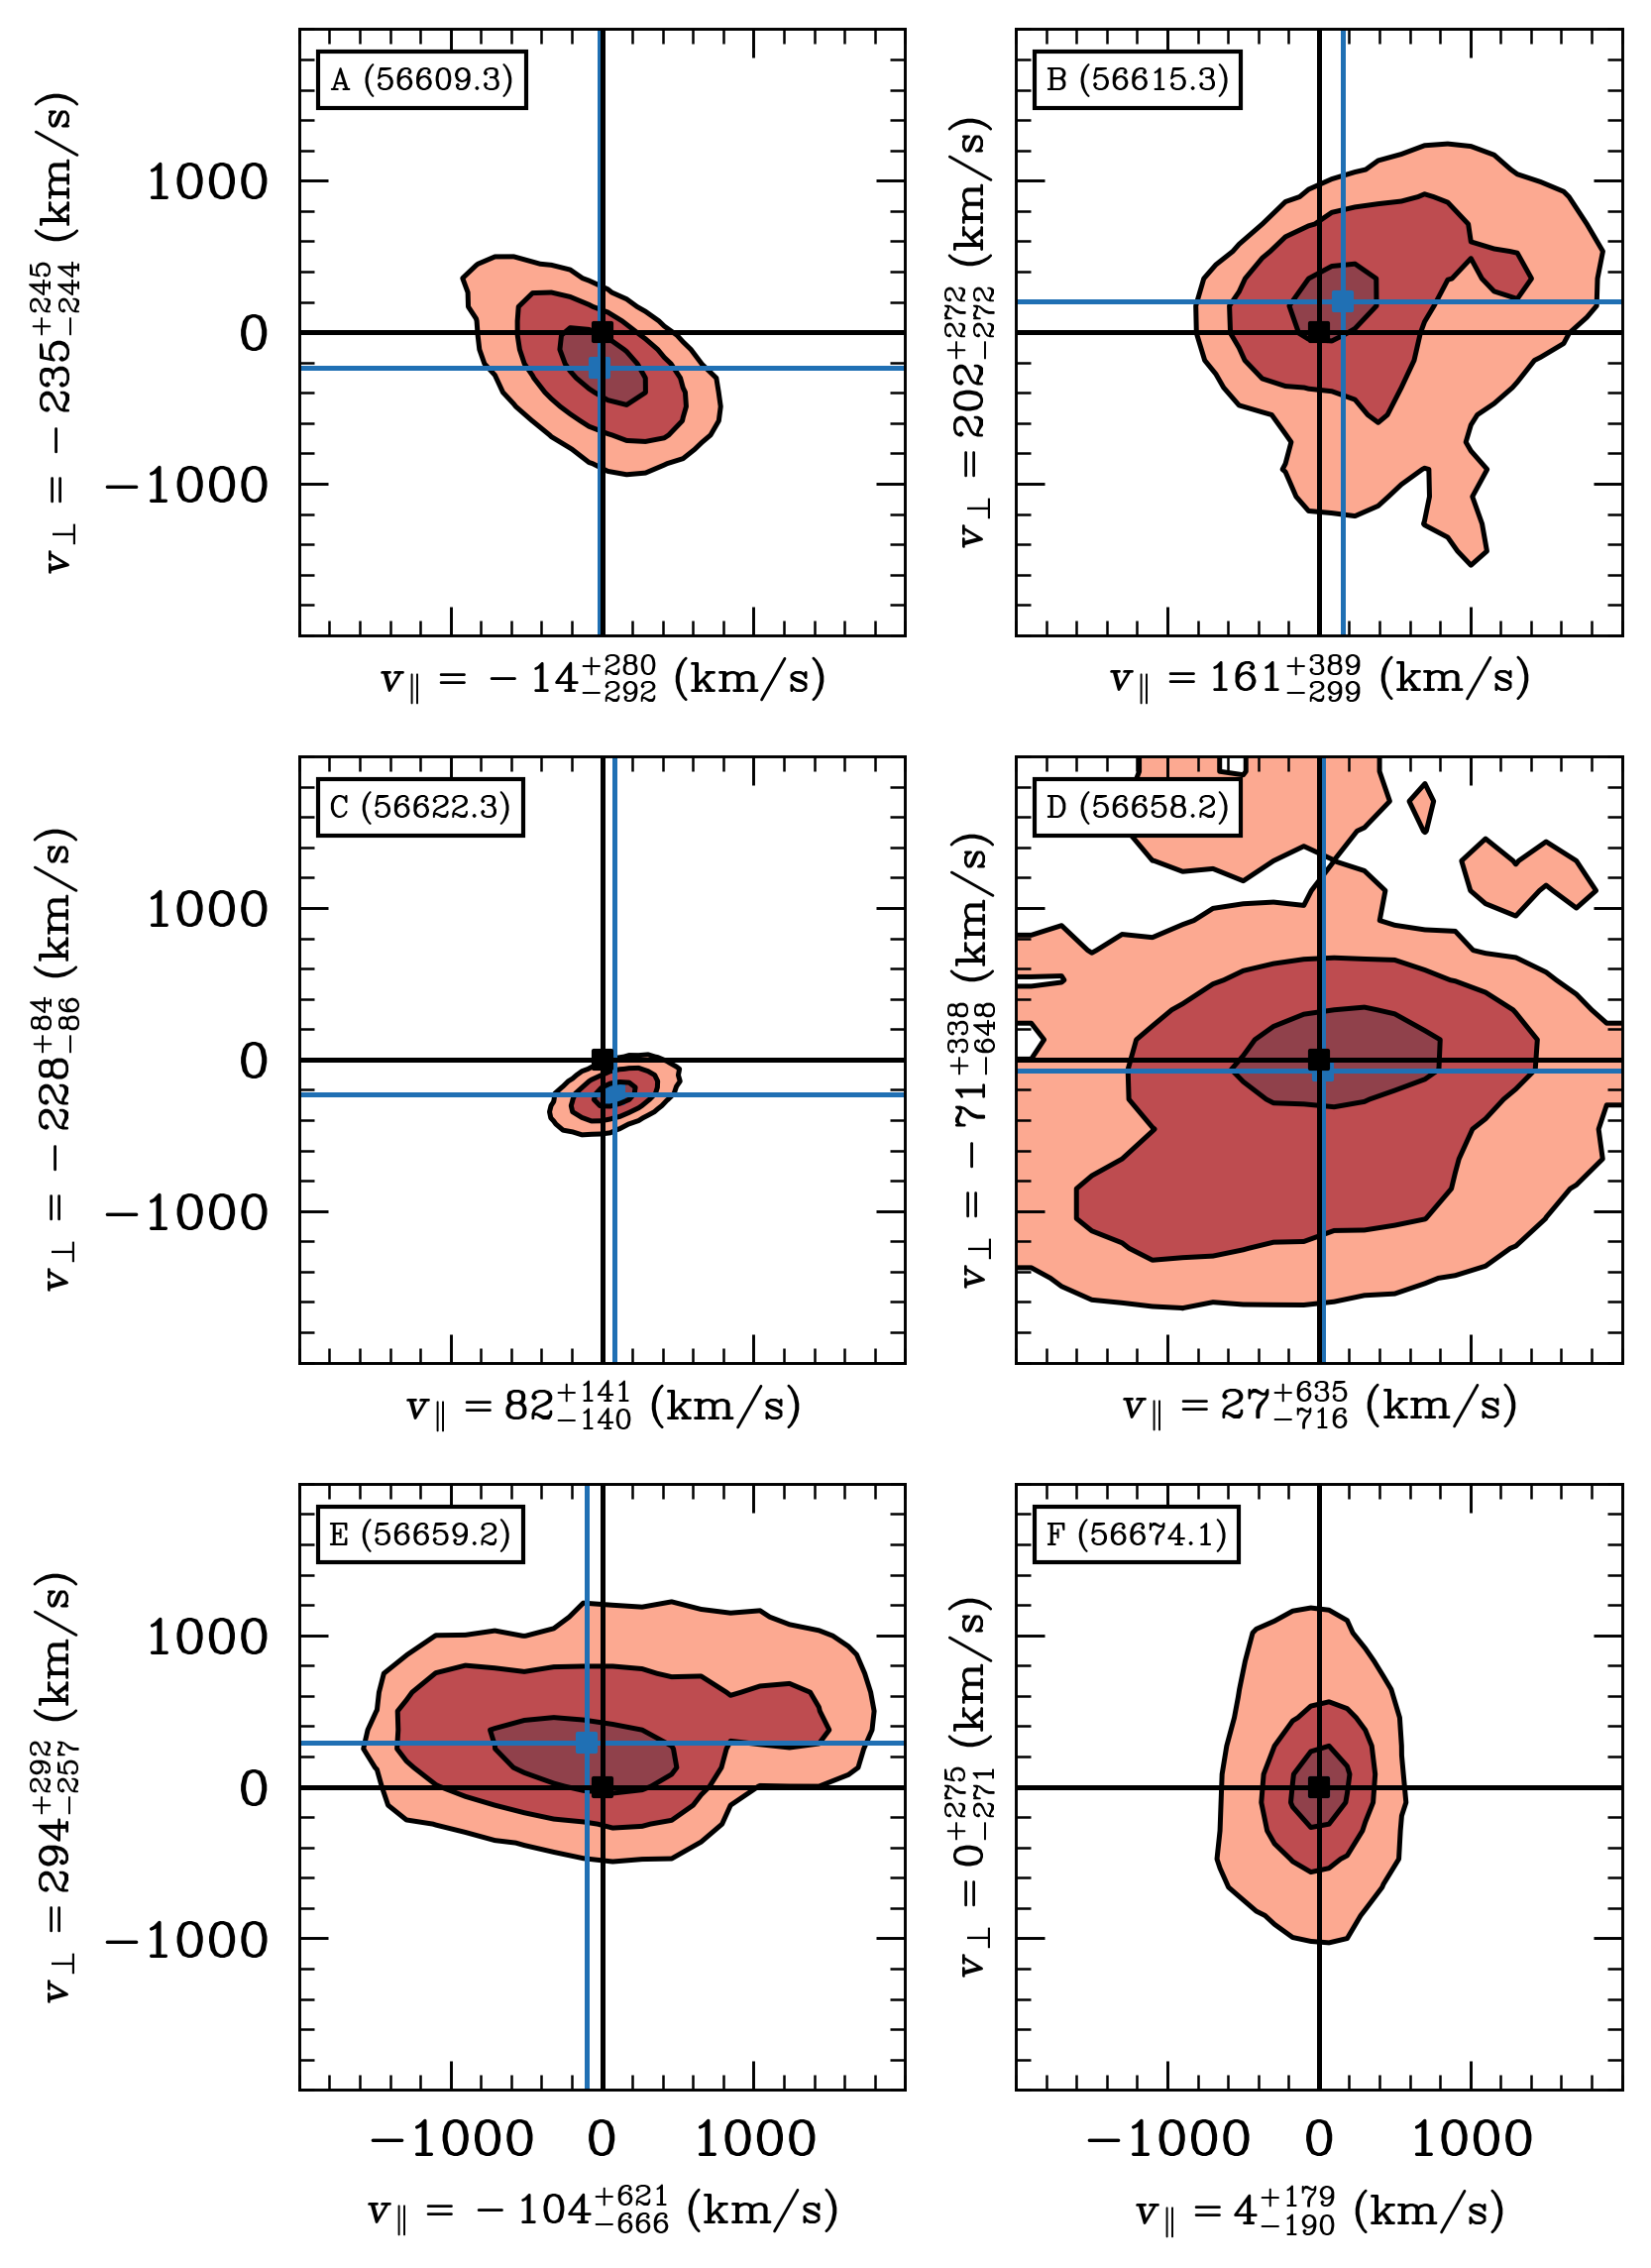

In [4]:
def gauss2d(x, y, sigmax, sigmay):
    return np.exp(-0.5 * (x**2 / sigmax**2 + y**2 / sigmay**2))


cmap = mpl.cm.Reds

fig, ax = plt.subplots(3, 2, figsize=(7, 9), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=-0.2)

for i, epoch in enumerate(epochs):
    sampler = emcee.backends.HDFBackend(
        data_path + epochs[i] + "_" + target + "_velocity_chain.h5"
    )
    samples = sampler.get_chain(flat=True)

    samples[:, 0] = d * (samples[:, 0] * mas) / (24 * 60 * 60) / 1e3  # mas/day -> km/s
    samples[:, 2] = d * (samples[:, 2] * mas) / (24 * 60 * 60) / 1e3  # mas/day -> km/s
    x = samples[:, 0]
    y = samples[:, 2]

    x_per = np.percentile(x, [16, 50, 84])
    y_per = np.percentile(y, [16, 50, 84])

    corner.hist2d(
        x,
        y,
        levels=(0.393, 0.865, 0.989),
        ax=ax[i // 2, i % 2],
        plot_datapoints=False,
        plot_contours=True,
        fill_contours=True,
        contourf_kwargs={
            "colors": ("white", cmap(0.393), cmap(0.865), cmap(0.989)),
            "alpha": 0.75,
        },
    )

    ax[i // 2, i % 2].axvline(0, color="black", zorder=10)
    ax[i // 2, i % 2].axhline(0, color="black", zorder=10)
    ax[i // 2, i % 2].scatter([0], [0], marker="s", color="black", s=20, zorder=10)

    ax[i // 2, i % 2].axvline(x_per[1], color=mpl.cm.Blues(0.75))
    ax[i // 2, i % 2].axhline(y_per[1], color=mpl.cm.Blues(0.75))
    ax[i // 2, i % 2].scatter(
        [x_per[1]], [y_per[1]], marker="s", color=mpl.cm.Blues(0.75), s=20
    )

    ax[i // 2, i % 2].annotate(
        "%s (%.1f)" % (epoch, mean_mjd[i]),
        xy=(0.05, 0.9),
        xycoords="axes fraction",
        fontsize=9,
        bbox={"boxstyle": "square", "facecolor": "white", "edgecolor": "black"},
    )

    ax[i // 2, i % 2].set_xlabel(
        r"$v_{\parallel}=%2.0f^{+%2.0f}_{-%2.0f}$ (km/s)"
        % (x_per[1], x_per[2] - x_per[1], x_per[1] - x_per[0]),
        fontsize=12,
    )
    ax[i // 2, i % 2].set_ylabel(
        r"$v_{\perp}=%2.0f^{+%2.0f}_{-%2.0f}$ (km/s)"
        % (y_per[1], y_per[2] - y_per[1], y_per[1] - y_per[0]),
        fontsize=12,
    )

    ax[i // 2, i % 2].set_aspect("equal")
    ax[i // 2, i % 2].set_xticks(1000 * np.arange(-1, 2))
    ax[i // 2, i % 2].set_xticklabels(1000 * np.arange(-1, 2))
    ax[i // 2, i % 2].set_yticks(1000 * np.arange(-1, 2))
    ax[i // 2, i % 2].set_yticklabels(1000 * np.arange(-1, 2))

ax[0, 0].set_xlim(-2000, 2000)
ax[0, 0].set_ylim(-2000, 2000)
fig.set_facecolor("white")
fig.set_dpi(300)
plt.savefig(fig_path + "velocity_corner.pdf", bbox_inches="tight")
plt.show()